In [1]:
# Baseline Models for Air Quality Prediction
# Train and evaluate simple baseline models

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import pickle
from datetime import datetime

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (mean_squared_error, mean_absolute_error, 
                            r2_score, mean_absolute_percentage_error)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

print("=" * 70)
print("BASELINE MODELS - AIR QUALITY PREDICTION")
print("=" * 70)

BASELINE MODELS - AIR QUALITY PREDICTION


In [2]:
# =============================================================================
# 1. LOAD DATA AND FEATURES
# =============================================================================

print("\n📂 LOADING DATA AND FEATURE SETS...")
print("-" * 70)

# Load train, validation, and test sets
train_path = Path('../data/processed/features_train.csv')
val_path = Path('../data/processed/features_val.csv')
test_path = Path('../data/processed/features_test.csv')

df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)
df_test = pd.read_csv(test_path)

print(f"✓ Train set: {len(df_train):,} records")
print(f"✓ Val set: {len(df_val):,} records")
print(f"✓ Test set: {len(df_test):,} records")

# Load feature sets
feature_sets_path = Path('../data/processed/feature_sets.json')
with open(feature_sets_path, 'r') as f:
    feature_sets = json.load(f)

print(f"\n✓ Loaded feature sets:")
for set_name, features in feature_sets.items():
    print(f"  {set_name:.<20} {len(features)} features")


📂 LOADING DATA AND FEATURE SETS...
----------------------------------------------------------------------
✓ Train set: 15,789 records
✓ Val set: 3,383 records
✓ Test set: 3,384 records

✓ Loaded feature sets:
  minimal............. 20 features
  balanced............ 50 features
  comprehensive....... 33 features


In [3]:
# =============================================================================
# 2. PREPARE DATA FOR MODELING
# =============================================================================

print("\n" + "=" * 70)
print("🎯 PREPARING DATA FOR MODELING")
print("=" * 70)

# Target variable
target = 'aqi'

# Exclude columns
exclude_cols = ['timestamp', 'aqi', 'aqi_original', 'date', 
                'city_name', 'country_code', 'source', 
                'location', 'city', 'country', 'state',
                'latitude', 'longitude', 'aqi_category']

# Add aqi_cat_ columns to exclude (data leakage)
aqi_cat_cols = [c for c in df_train.columns if c.startswith('aqi_cat_')]
exclude_cols.extend(aqi_cat_cols)

# Function to prepare dataset
def prepare_data(df, feature_list):
    """Prepare features and target, handling missing values"""
    # Select features
    available_features = [f for f in feature_list if f in df.columns]
    
    # Create feature matrix and target
    X = df[available_features].copy()
    y = df[target].copy()
    
    # Remove rows with missing target
    mask = y.notna()
    X = X[mask]
    y = y[mask]
    
    # Fill missing features with median
    X = X.fillna(X.median())
    
    return X, y, available_features

# Prepare data for each feature set
data_prepared = {}

for set_name, features in feature_sets.items():
    X_train, y_train, train_features = prepare_data(df_train, features)
    X_val, y_val, _ = prepare_data(df_val, features)
    X_test, y_test, _ = prepare_data(df_test, features)
    
    data_prepared[set_name] = {
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val,
        'X_test': X_test,
        'y_test': y_test,
        'features': train_features
    }
    
    print(f"\n{set_name.upper()} SET:")
    print(f"  Features used: {len(train_features)}")
    print(f"  Train samples: {len(X_train):,}")
    print(f"  Val samples: {len(X_val):,}")
    print(f"  Test samples: {len(X_test):,}")


🎯 PREPARING DATA FOR MODELING

MINIMAL SET:
  Features used: 20
  Train samples: 15,789
  Val samples: 3,383
  Test samples: 3,384

BALANCED SET:
  Features used: 50
  Train samples: 15,789
  Val samples: 3,383
  Test samples: 3,384

COMPREHENSIVE SET:
  Features used: 33
  Train samples: 15,789
  Val samples: 3,383
  Test samples: 3,384


In [4]:
# =============================================================================
# 3. DEFINE EVALUATION METRICS
# =============================================================================

print("\n" + "=" * 70)
print("📊 EVALUATION METRICS")
print("=" * 70)

def evaluate_model(y_true, y_pred, model_name="Model"):
    """Calculate comprehensive evaluation metrics"""
    metrics = {
        'Model': model_name,
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R²': r2_score(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred) * 100
    }
    return metrics

def print_metrics(metrics_dict):
    """Pretty print metrics"""
    df_metrics = pd.DataFrame([metrics_dict])
    print(df_metrics.to_string(index=False))
    return df_metrics


📊 EVALUATION METRICS


In [5]:
# =============================================================================
# 4. BASELINE MODEL 1: SIMPLE MEAN PREDICTOR
# =============================================================================

print("\n" + "=" * 70)
print("📈 BASELINE 1: MEAN PREDICTOR (Dummy Baseline)")
print("=" * 70)

# Use balanced set for baselines
data = data_prepared['balanced']

# Simple mean predictor
mean_aqi = data['y_train'].mean()
y_pred_mean = np.full(len(data['y_val']), mean_aqi)

print(f"Mean AQI from training: {mean_aqi:.2f}")

metrics_mean = evaluate_model(data['y_val'], y_pred_mean, "Mean Predictor")
df_metrics_mean = print_metrics(metrics_mean)

print(f"\n💡 This is our MINIMUM baseline - any model must beat this!")


📈 BASELINE 1: MEAN PREDICTOR (Dummy Baseline)
Mean AQI from training: 54.75
         Model      RMSE       MAE        R²       MAPE
Mean Predictor 87.574118 61.199444 -0.093136 339.474309

💡 This is our MINIMUM baseline - any model must beat this!


In [6]:
# =============================================================================
# 5. BASELINE MODEL 2: LINEAR REGRESSION
# =============================================================================

print("\n" + "=" * 70)
print("📈 BASELINE 2: LINEAR REGRESSION")
print("=" * 70)

# Train Linear Regression
lr = LinearRegression()
lr.fit(data['X_train'], data['y_train'])

# Predictions
y_pred_lr_train = lr.predict(data['X_train'])
y_pred_lr_val = lr.predict(data['X_val'])
y_pred_lr_test = lr.predict(data['X_test'])

# Evaluate
print("\n📊 Training Set:")
metrics_lr_train = evaluate_model(data['y_train'], y_pred_lr_train, "LR - Train")
print_metrics(metrics_lr_train)

print("\n📊 Validation Set:")
metrics_lr_val = evaluate_model(data['y_val'], y_pred_lr_val, "LR - Val")
print_metrics(metrics_lr_val)

print("\n📊 Test Set:")
metrics_lr_test = evaluate_model(data['y_test'], y_pred_lr_test, "LR - Test")
print_metrics(metrics_lr_test)

# Feature importance (coefficients)
feature_importance_lr = pd.DataFrame({
    'feature': data['features'],
    'coefficient': np.abs(lr.coef_)
}).sort_values('coefficient', ascending=False)

print("\n🔝 Top 10 Most Important Features (Linear Regression):")
print(feature_importance_lr.head(10).to_string(index=False))



📈 BASELINE 2: LINEAR REGRESSION

📊 Training Set:
     Model      RMSE      MAE       R²     MAPE
LR - Train 15.194018 2.011882 0.935751 4.560665

📊 Validation Set:
   Model      RMSE      MAE       R²     MAPE
LR - Val 13.194462 2.002777 0.975185 4.695717

📊 Test Set:
    Model      RMSE     MAE       R²     MAPE
LR - Test 16.068738 2.90538 0.965925 5.749215

🔝 Top 10 Most Important Features (Linear Regression):
             feature  coefficient
pm10_rolling_3h_mean     2.613915
 aqi_rolling_3h_mean     2.271398
pm25_rolling_6h_mean     1.179875
 aqi_rolling_6h_mean     0.986375
 pm10_rolling_3h_max     0.933633
 pm10_rolling_3h_min     0.782371
 pm25_rolling_3h_max     0.671844
 pm25_rolling_3h_min     0.639971
         pm10_lag_1h     0.517522
          aqi_lag_1h     0.500483


In [7]:
# =============================================================================
# 6. BASELINE MODEL 3: RIDGE REGRESSION
# =============================================================================

print("\n" + "=" * 70)
print("📈 BASELINE 3: RIDGE REGRESSION (L2 Regularization)")
print("=" * 70)

# Standardize features for regularization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(data['X_train'])
X_val_scaled = scaler.transform(data['X_val'])
X_test_scaled = scaler.transform(data['X_test'])

# Train Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, data['y_train'])

# Predictions
y_pred_ridge_val = ridge.predict(X_val_scaled)
y_pred_ridge_test = ridge.predict(X_test_scaled)

print("\n📊 Validation Set:")
metrics_ridge_val = evaluate_model(data['y_val'], y_pred_ridge_val, "Ridge - Val")
print_metrics(metrics_ridge_val)

print("\n📊 Test Set:")
metrics_ridge_test = evaluate_model(data['y_test'], y_pred_ridge_test, "Ridge - Test")
print_metrics(metrics_ridge_test)


📈 BASELINE 3: RIDGE REGRESSION (L2 Regularization)

📊 Validation Set:
      Model      RMSE      MAE       R²     MAPE
Ridge - Val 13.198954 1.994693 0.975169 4.784847

📊 Test Set:
       Model      RMSE      MAE       R²     MAPE
Ridge - Test 15.892644 2.846203 0.966667 5.818035


,Model,RMSE,MAE,R²,MAPE
0,Ridge - Test,15.892644,2.846203,0.966667,5.818035


In [8]:
# =============================================================================
# 7. BASELINE MODEL 4: RANDOM FOREST (Simple)
# =============================================================================

print("\n" + "=" * 70)
print("📈 BASELINE 4: RANDOM FOREST (Simple Configuration)")
print("=" * 70)

# Train Random Forest
rf_baseline = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest...")
rf_baseline.fit(data['X_train'], data['y_train'])

# Predictions
y_pred_rf_train = rf_baseline.predict(data['X_train'])
y_pred_rf_val = rf_baseline.predict(data['X_val'])
y_pred_rf_test = rf_baseline.predict(data['X_test'])

print("\n📊 Training Set:")
metrics_rf_train = evaluate_model(data['y_train'], y_pred_rf_train, "RF - Train")
print_metrics(metrics_rf_train)

print("\n📊 Validation Set:")
metrics_rf_val = evaluate_model(data['y_val'], y_pred_rf_val, "RF - Val")
print_metrics(metrics_rf_val)

print("\n📊 Test Set:")
metrics_rf_test = evaluate_model(data['y_test'], y_pred_rf_test, "RF - Test")
print_metrics(metrics_rf_test)

# Feature importance
feature_importance_rf = pd.DataFrame({
    'feature': data['features'],
    'importance': rf_baseline.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔝 Top 10 Most Important Features (Random Forest):")
print(feature_importance_rf.head(10).to_string(index=False))


📈 BASELINE 4: RANDOM FOREST (Simple Configuration)
Training Random Forest...

📊 Training Set:
     Model     RMSE      MAE      R²   MAPE
RF - Train 5.253193 0.355529 0.99232 0.3504

📊 Validation Set:
   Model      RMSE      MAE       R²     MAPE
RF - Val 15.073304 2.218441 0.967615 0.816614

📊 Test Set:
    Model      RMSE      MAE       R²     MAPE
RF - Test 12.262522 1.736509 0.980156 1.088079

🔝 Top 10 Most Important Features (Random Forest):
             feature  importance
 aqi_rolling_3h_mean    0.742483
                pm25    0.201426
pm25_rolling_6h_mean    0.009850
 pm25_rolling_6h_max    0.006255
          aqi_lag_1h    0.005024
  aqi_rolling_3h_max    0.003817
pm25_rolling_12h_max    0.002355
          aqi_lag_3h    0.002307
 pm25_rolling_3h_max    0.002222
 pm25_rolling_6h_min    0.001949



📊 BASELINE MODELS COMPARISON

📊 Validation Set Performance:
         Model      RMSE       MAE        R²       MAPE
Mean Predictor 87.574118 61.199444 -0.093136 339.474309
      LR - Val 13.194462  2.002777  0.975185   4.695717
   Ridge - Val 13.198954  1.994693  0.975169   4.784847
      RF - Val 15.073304  2.218441  0.967615   0.816614


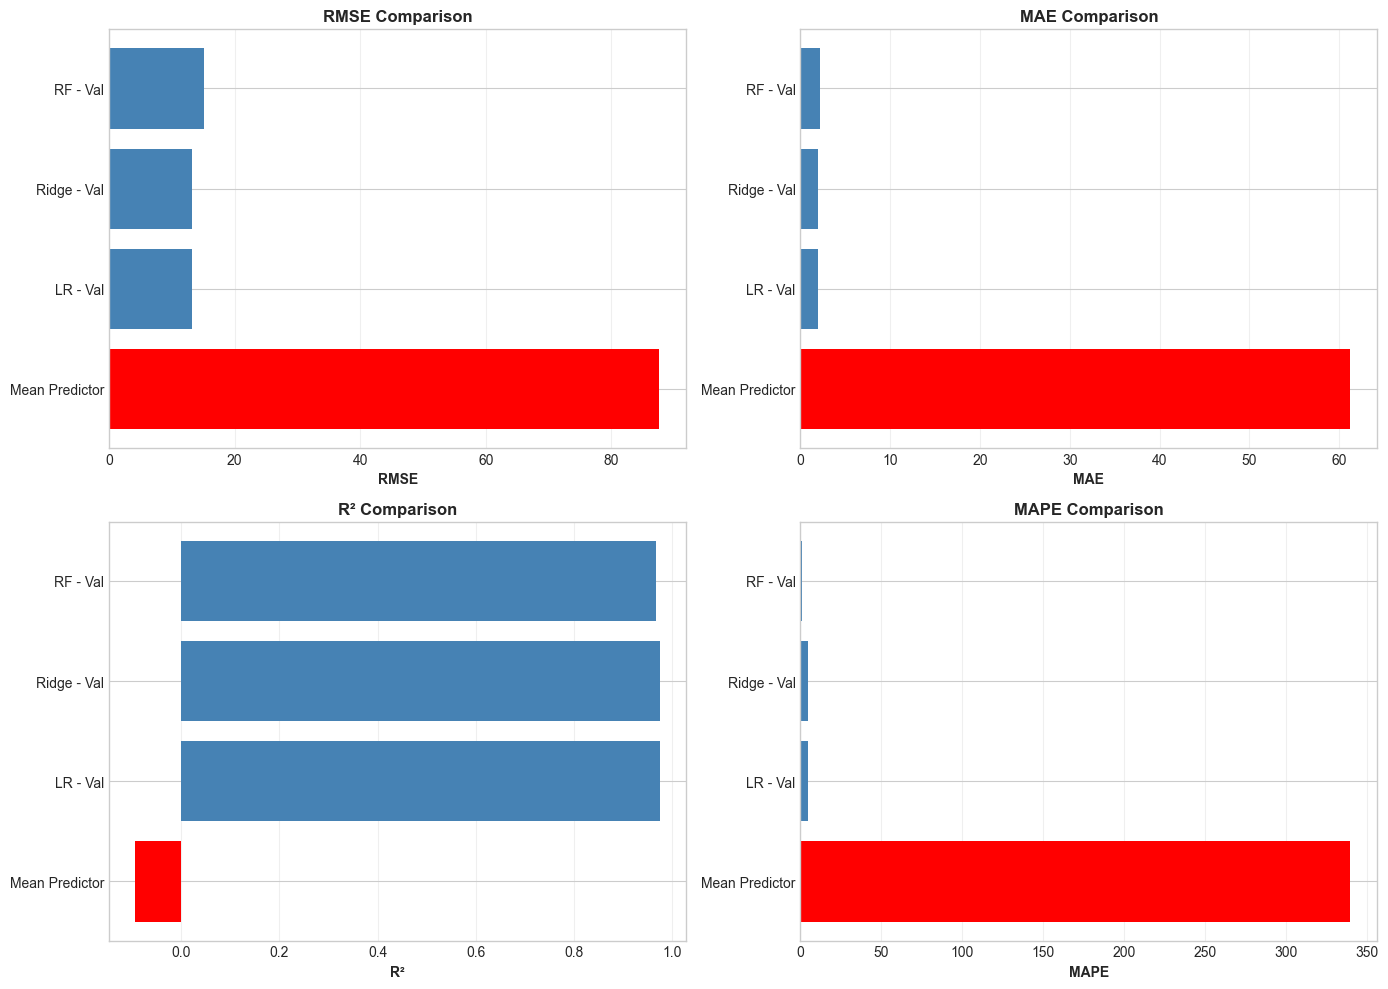


🏆 Model Rankings (by R²):
         Model        R²      RMSE       MAE  Rank
      LR - Val  0.975185 13.194462  2.002777     1
   Ridge - Val  0.975169 13.198954  1.994693     2
      RF - Val  0.967615 15.073304  2.218441     3
Mean Predictor -0.093136 87.574118 61.199444     4


In [9]:
# =============================================================================
# 8. COMPARE ALL BASELINE MODELS
# =============================================================================

print("\n" + "=" * 70)
print("📊 BASELINE MODELS COMPARISON")
print("=" * 70)

# Compile all validation metrics
all_metrics = pd.DataFrame([
    metrics_mean,
    metrics_lr_val,
    metrics_ridge_val,
    metrics_rf_val
])

print("\n📊 Validation Set Performance:")
print(all_metrics.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

models = all_metrics['Model'].tolist()
metrics_to_plot = ['RMSE', 'MAE', 'R²', 'MAPE']

for idx, metric in enumerate(metrics_to_plot):
    ax = axes[idx // 2, idx % 2]
    values = all_metrics[metric].values
    colors = ['red' if m == 'Mean Predictor' else 'steelblue' for m in models]
    
    ax.barh(models, values, color=colors)
    ax.set_xlabel(metric, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Rank models
all_metrics['Rank'] = all_metrics['R²'].rank(ascending=False).astype(int)
all_metrics_sorted = all_metrics.sort_values('R²', ascending=False)

print("\n🏆 Model Rankings (by R²):")
print(all_metrics_sorted[['Model', 'R²', 'RMSE', 'MAE', 'Rank']].to_string(index=False))



📈 PREDICTION VISUALIZATIONS


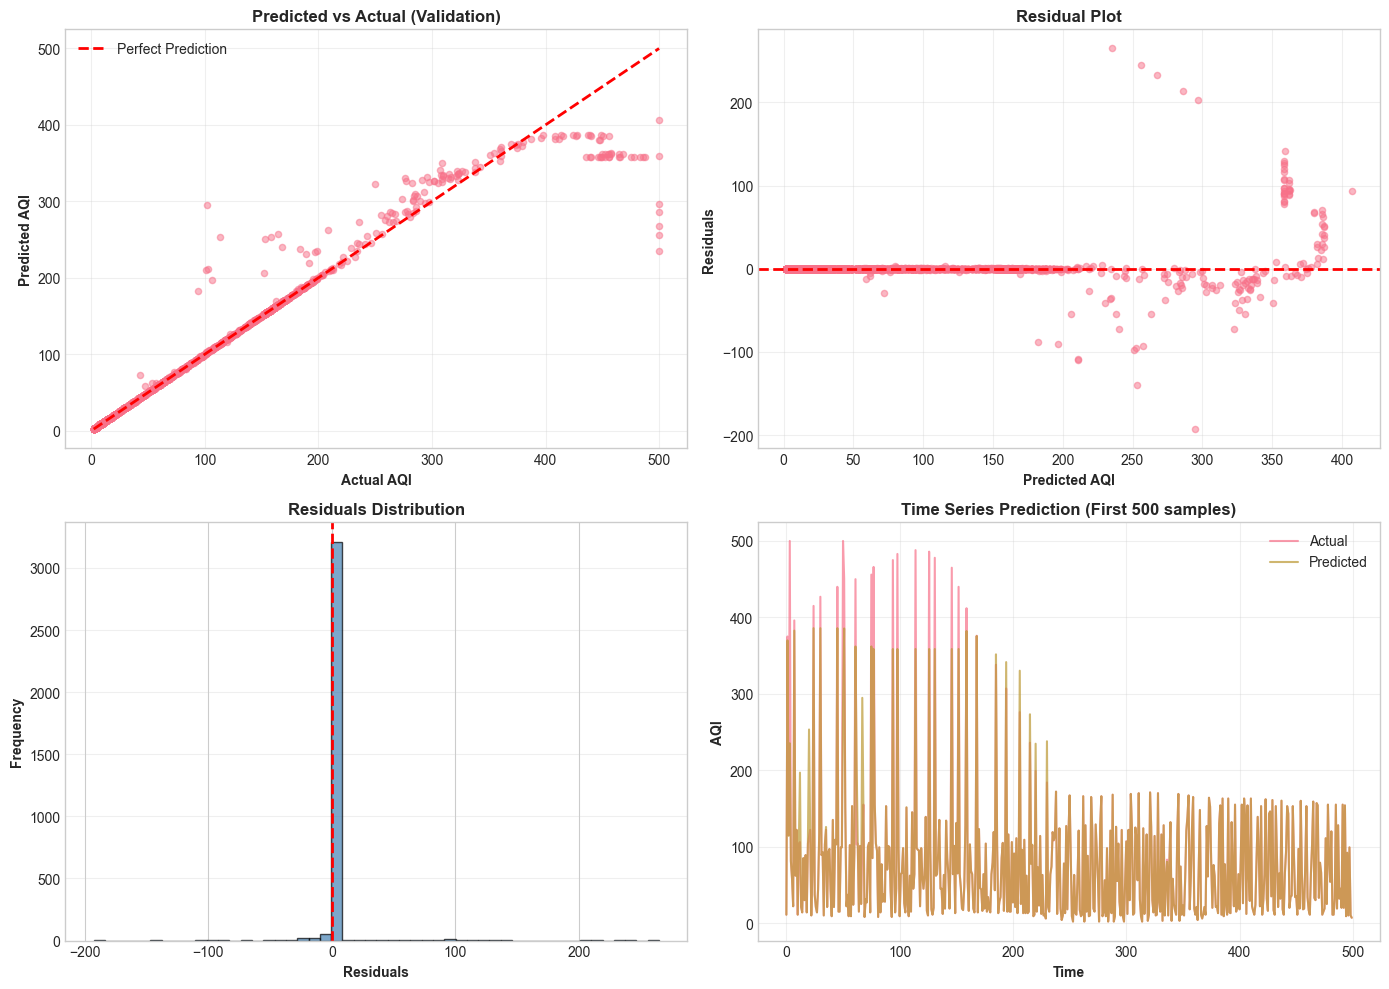

In [10]:
# =============================================================================
# 9. PREDICTION VISUALIZATIONS
# =============================================================================

print("\n" + "=" * 70)
print("📈 PREDICTION VISUALIZATIONS")
print("=" * 70)

# Use Random Forest (best baseline) for visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Predicted vs Actual (Validation)
axes[0, 0].scatter(data['y_val'], y_pred_rf_val, alpha=0.5, s=20)
axes[0, 0].plot([data['y_val'].min(), data['y_val'].max()], 
                [data['y_val'].min(), data['y_val'].max()], 
                'r--', lw=2, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual AQI', fontweight='bold')
axes[0, 0].set_ylabel('Predicted AQI', fontweight='bold')
axes[0, 0].set_title('Predicted vs Actual (Validation)', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Residuals
residuals = data['y_val'] - y_pred_rf_val
axes[0, 1].scatter(y_pred_rf_val, residuals, alpha=0.5, s=20)
axes[0, 1].axhline(0, color='red', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted AQI', fontweight='bold')
axes[0, 1].set_ylabel('Residuals', fontweight='bold')
axes[0, 1].set_title('Residual Plot', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Residuals Distribution
axes[1, 0].hist(residuals, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(0, color='red', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Residuals', fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontweight='bold')
axes[1, 0].set_title('Residuals Distribution', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: Time Series Prediction (Sample)
sample_size = min(500, len(data['y_val']))
axes[1, 1].plot(range(sample_size), data['y_val'].iloc[:sample_size].values, 
                label='Actual', linewidth=1.5, alpha=0.7)
axes[1, 1].plot(range(sample_size), y_pred_rf_val[:sample_size], 
                label='Predicted', linewidth=1.5, alpha=0.7)
axes[1, 1].set_xlabel('Time', fontweight='bold')
axes[1, 1].set_ylabel('AQI', fontweight='bold')
axes[1, 1].set_title(f'Time Series Prediction (First {sample_size} samples)', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



🔍 ERROR ANALYSIS

📊 Error Analysis by AQI Category:
                               Count  Mean_Error  Median_Error  Max_Error
AQI_Category                                                             
Good (0-50)                     1633        0.03          0.00      29.27
Hazardous (301+)                  90       57.22         32.17     264.74
Moderate (51-100)                673        0.20          0.00      88.45
Unhealthy (151-200)              651        0.99          0.00      97.85
Unhealthy Sensitive (101-150)    274        2.50          0.04     192.72
Very Unhealthy (201-300)          62       13.60          6.88      72.77


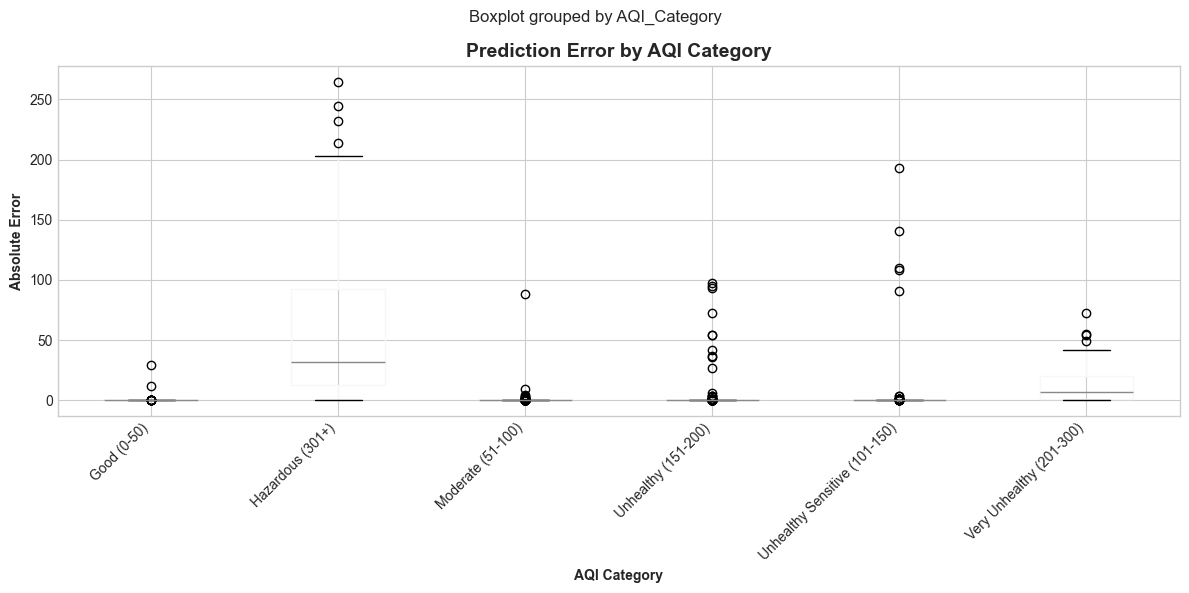

In [11]:
# =============================================================================
# 10. ERROR ANALYSIS
# =============================================================================

print("\n" + "=" * 70)
print("🔍 ERROR ANALYSIS")
print("=" * 70)

# Analyze errors by AQI range
y_val_array = data['y_val'].values
errors = np.abs(y_val_array - y_pred_rf_val)

# Define AQI categories
def get_aqi_category(aqi):
    if aqi <= 50:
        return 'Good (0-50)'
    elif aqi <= 100:
        return 'Moderate (51-100)'
    elif aqi <= 150:
        return 'Unhealthy Sensitive (101-150)'
    elif aqi <= 200:
        return 'Unhealthy (151-200)'
    elif aqi <= 300:
        return 'Very Unhealthy (201-300)'
    else:
        return 'Hazardous (301+)'

categories = [get_aqi_category(aqi) for aqi in y_val_array]

error_by_category = pd.DataFrame({
    'AQI_Category': categories,
    'Actual_AQI': y_val_array,
    'Predicted_AQI': y_pred_rf_val,
    'Error': errors
})

error_summary = error_by_category.groupby('AQI_Category')['Error'].agg([
    ('Count', 'count'),
    ('Mean_Error', 'mean'),
    ('Median_Error', 'median'),
    ('Max_Error', 'max')
]).round(2)

print("\n📊 Error Analysis by AQI Category:")
print(error_summary)

# Visualize
fig, ax = plt.subplots(figsize=(12, 6))
error_by_category.boxplot(column='Error', by='AQI_Category', ax=ax)
ax.set_title('Prediction Error by AQI Category', fontweight='bold', fontsize=14)
ax.set_xlabel('AQI Category', fontweight='bold')
ax.set_ylabel('Absolute Error', fontweight='bold')
plt.sca(ax)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [12]:
# =============================================================================
# 11. SAVE BASELINE MODELS
# =============================================================================

print("\n" + "=" * 70)
print("💾 SAVING BASELINE MODELS")
print("=" * 70)

# Create models directory
models_dir = Path('../data/models')
models_dir.mkdir(exist_ok=True)

# Save best baseline (Random Forest)
model_path = models_dir / 'baseline_random_forest.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(rf_baseline, f)
print(f"✓ Saved: {model_path}")

# Save scaler (for Ridge)
scaler_path = models_dir / 'scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✓ Saved: {scaler_path}")

# Save metrics
metrics_path = models_dir / 'baseline_metrics.csv'
all_metrics.to_csv(metrics_path, index=False)
print(f"✓ Saved: {metrics_path}")

# Save feature importance
importance_path = models_dir / 'baseline_feature_importance.csv'
feature_importance_rf.to_csv(importance_path, index=False)
print(f"✓ Saved: {importance_path}")

print("\n" + "=" * 70)
print("✅ BASELINE MODELS COMPLETE!")
print("=" * 70)

print("\n📊 Summary:")
print(f"  Best Model: Random Forest")
print(f"  Validation R²: {metrics_rf_val['R²']:.4f}")
print(f"  Validation RMSE: {metrics_rf_val['RMSE']:.2f}")
print(f"  Validation MAE: {metrics_rf_val['MAE']:.2f}")

print("\n🎯 Next Steps:")
print("1. Review error analysis by AQI category")
print("2. Proceed to advanced models (XGBoost, LightGBM)")
print("3. Try hyperparameter tuning")
print("4. Experiment with LSTM for time-series")


💾 SAVING BASELINE MODELS
✓ Saved: ..\data\models\baseline_random_forest.pkl
✓ Saved: ..\data\models\scaler.pkl
✓ Saved: ..\data\models\baseline_metrics.csv
✓ Saved: ..\data\models\baseline_feature_importance.csv

✅ BASELINE MODELS COMPLETE!

📊 Summary:
  Best Model: Random Forest
  Validation R²: 0.9676
  Validation RMSE: 15.07
  Validation MAE: 2.22

🎯 Next Steps:
1. Review error analysis by AQI category
2. Proceed to advanced models (XGBoost, LightGBM)
3. Try hyperparameter tuning
4. Experiment with LSTM for time-series
